In [9]:
# keep refreshing the env to update experiments.json
%load_ext autoreload
%autoreload 2

# make cells take up the whole width to display graphs better
from IPython.display import display, HTML, Markdown
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

import json
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display
import ipywidgets as widgets
from scipy.optimize import curve_fit
from math import ceil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
experiment_filenames  = [
    # "experiments_20250201_224216.json",  # 4 OOMs FCN overfit on 1 data point for 5k epochs
    # "experiments_20250202_103858.json",   # 4 OOMs FCN overfit on 1 data point for 20k epochs with LR scheduler
    # "experiments_20250202_153806 copy.json",  # 4 OOMs FCN overfit on 1 data point for 20k epochs without LR scheduler
    # "experiments_20250202_164415 copy.json"    # 4 OOMs FCN overfit on 1 data point for 20k epochs without LR scheduler
    # "experiments_20250201_234945.json"   # 4 OOMs of FCN and data
    # "experiments_20250203_115635 copy.json"  # 4 OOMs FCN overfit on 1 data point for 20k epochs without LR scheduler LR=0.01
    "experiments_20250302_033428.json"
]

In [11]:
scaled_loss = True

### Helper funcs

In [12]:
def load_and_process_data(filename):
    """
    Load and process the experimental data from a JSON file.

    Args:
        filename (str): The name of the JSON file.

    Returns:
        summary_val (dict): Best achievable validation loss per dataset size.
        detailed_runs (dict): Detailed runs data structured by dataset size.
        loaded_data (dict): The raw loaded JSON data.
    """
    with open(f"results/{filename}", "r") as f:
        loaded_data = json.load(f)

    detailed_runs = {}  # {dataset_size: [(params, best_val_loss, best_train_loss), ...]}
    for ds_size_str, runs in loaded_data.items():
        ds_size = float(ds_size_str)
        run_losses = []
        for run in runs:
            val_losses = [step_data["val_loss"] for step_data in run["losses"].values() 
                         if "val_loss" in step_data]
            train_losses = [step_data["train_loss"] for step_data in run["losses"].values() 
                          if "train_loss" in step_data]
            best_val_loss = min(val_losses)
            best_train_loss = min(train_losses)
            num_params = run["config"]["num_params"]
            run_losses.append((num_params, best_val_loss, best_train_loss, run))  # Store run data for callbacks
        detailed_runs[ds_size] = run_losses

    # Create summary_results for scaling law plot
    summary_val = {}  # best achievable validation loss per dataset size
    for ds_size, runs in detailed_runs.items():
        best_val = min(l[1] for l in runs)
        summary_val[ds_size] = best_val

    return summary_val, detailed_runs, loaded_data

def prepare_scaling_data(summary_val):
    """
    Prepare and sort the scaling data.

    Args:
        summary_val (dict): Best achievable validation loss per dataset size.

    Returns:
        sorted_ds_sizes (np.array): Sorted dataset sizes.
        sorted_val_losses (np.array): Validation losses sorted accordingly.
    """
    ds_sizes = np.array(list(summary_val.keys()))
    val_losses = np.array(list(summary_val.values()))
    sorted_indices = np.argsort(ds_sizes)
    sorted_ds_sizes = ds_sizes[sorted_indices]
    sorted_val_losses = val_losses[sorted_indices]
    return sorted_ds_sizes, sorted_val_losses

def calculate_scaling_law(ds_sizes, val_losses):
    """
    Calculate the scaling law parameters and fitted values.

    Args:
        ds_sizes (np.array): Array of dataset sizes.
        val_losses (np.array): Array of validation losses.

    Returns:
        fitted_vals (np.array): Fitted validation loss values based on scaling law.
        a (float): Scaling law parameter a.
        b (float): Scaling law parameter b.
    """
    # Define the power-law function
    def power_law(x, a, b):
        return a * x ** (-b)

    # Fit the power-law curve to the data
    popt, _ = curve_fit(power_law, ds_sizes, val_losses, p0=(1, 1))  # Initial guess for a and b

    # Extract parameters
    a, b = popt

    fitted_vals = power_law(ds_sizes, a, b)
    return fitted_vals, a, b

### Prep data

In [13]:
# ------------------ buggy ------------------ 
# all FCN models 50 epochs
# experiment_filename = "experiments_20250111_214659.json"

# all Transformer models 50 epochs                          ********
# experiment_filename = "experiments_20250112_062438.json"

# ------------------ bugfix ------------------ 
# all Transformer models 50 epochs  
# experiment_filename = "experiments_20250123_155336.json"

# ------------------ all loss equally scaled ------------------ 
# experiment_filename = "experiments_20250123_162306.json"


# ------------------ low batch size (8) on 0.1 fraction ------------------ 
# experiment_filename = "experiments_20250123_163741.json"

# ------------------ low batch size (8) ------------------ 
# 0.01 0.02 0.04 0.08
# experiment_filename = "experiments_20250124_102758.json"
# 0.1 0.2 0.4 0.8 1.0
# experiment_filename = "experiments_20250123_165735.json"
# experiment_filename_1 = "merged.json"

In [14]:
# Initialize dictionaries to store data for all experiments
all_summary_vals = {}
all_detailed_runs = {}
all_loaded_data = {}
all_sorted_ds_sizes = {}
all_sorted_val_losses = {}
all_fitted_vals = {}
all_scaling_params = {}

# Load and process each experiment file
for filename in experiment_filenames:
    summary_val, detailed_runs, loaded_data = load_and_process_data(filename)
    sorted_ds_sizes, sorted_val_losses = prepare_scaling_data(summary_val)
    # fitted_vals, a, b = calculate_scaling_law(sorted_ds_sizes, sorted_val_losses)
    
    # Store data in dictionaries
    all_summary_vals[filename] = summary_val
    all_detailed_runs[filename] = detailed_runs
    all_loaded_data[filename] = loaded_data
    all_sorted_ds_sizes[filename] = sorted_ds_sizes
    all_sorted_val_losses[filename] = sorted_val_losses
    # all_fitted_vals[filename] = fitted_vals
    # all_scaling_params[filename] = (a, b)

### Create plots

In [15]:
# Create Plot-1 (Scaling Law for Validation Loss)
fig_plot1 = go.FigureWidget()

# Define color and marker styles for different experiments
color_palette = px.colors.qualitative.Plotly
marker_symbols = ['circle', 'square', 'diamond', 'cross', 'triangle-up', 'triangle-down', 'star']

color_map = {}
marker_map = {}

# Determine the overall min and max for dataset sizes to place baseline lines properly
all_x_values = []
for idx, filename in enumerate(experiment_filenames):
    all_x_values.extend(all_sorted_ds_sizes[filename])
min_x = min(all_x_values) if all_x_values else 0
max_x = max(all_x_values) if all_x_values else 1

# Ensure we don't get zero-range for lines
if max_x == min_x:
    max_x = min_x + 1

for idx, filename in enumerate(experiment_filenames):
    color = color_palette[idx % len(color_palette)]
    marker = marker_symbols[idx % len(marker_symbols)]
    color_map[filename] = color
    marker_map[filename] = marker

    # Extract data
    sorted_ds_sizes = all_sorted_ds_sizes[filename]
    sorted_val_losses = all_sorted_val_losses[filename]

    # Original Data Trace
    fig_plot1.add_trace(
        go.Scatter(
            x=sorted_ds_sizes,
            y=sorted_val_losses,
            mode='lines+markers',
            name=f'Best Val Loss<br>{filename}',
            marker=dict(symbol=marker, size=8, color=color),
            customdata=[{'experiment': filename, 'dataset_size': ds} for ds in sorted_ds_sizes],
            hovertemplate='Dataset Size: %{x}<br>Val Loss: %{y}<extra></extra>',
        )
    )

# Add the 3 baseline dashed lines
if scaled_loss:
    zero_everywhere =  275.235
    mean_everywhere = 267.801
    k_one =  268.464
else:
    zero_everywhere = 17.559
    mean_everywhere = 14.579
    k_one = 13.908
fig_plot1.add_trace(
    go.Scatter(
        x=[min_x, max_x],
        y=[zero_everywhere, zero_everywhere],
        mode='lines',
        line=dict(color='#808080', dash='dash'),
        name='Naive 0 Everywhere'
    )
)
fig_plot1.add_trace(
    go.Scatter(
        x=[min_x, max_x],
        y=[mean_everywhere, mean_everywhere],
        mode='lines',
        line=dict(color='#003262', dash='dash'),
        name='Naive Mean'
    )
)
fig_plot1.add_trace(
    go.Scatter(
        x=[min_x, max_x],
        y=[k_one, k_one],
        mode='lines',
        line=dict(color='#FDB515', dash='dash'),
        name='Naive k=1'
    )
)

fig_plot1.update_layout(
    title="Scaling Law: Validation Loss vs Dataset Size",
    xaxis_title="Dataset Size",
    yaxis_title="Validation Loss",
    template="plotly_white",
    width=900,
    height=600,
    legend=dict(x=1.02, y=1)
)

# Add buttons for toggling axis scales
xaxis_buttons = [
    dict(args=[{"xaxis.type": "linear"}], label="X-Linear", method="relayout"),
    dict(args=[{"xaxis.type": "log"}], label="X-Log", method="relayout")
]
yaxis_buttons = [
    dict(args=[{"yaxis.type": "linear"}], label="Y-Linear", method="relayout"),
    dict(args=[{"yaxis.type": "log"}], label="Y-Log", method="relayout")
]
fig_plot1.update_layout(
    margin=dict(r=150),
    updatemenus=[
        dict(type="buttons", direction="up", x=1.02, y=0.05, xanchor="left", yanchor="bottom",
             showactive=True, buttons=xaxis_buttons, name="xaxis_buttons"),
        dict(type="buttons", direction="up", x=1.145, y=0.05, xanchor="left", yanchor="bottom",
             showactive=True, buttons=yaxis_buttons, name="yaxis_buttons")
    ]
)

# Create Plot-2 (Saturation Curves for Train Loss)
fig_train_loss = go.FigureWidget()
fig_train_loss.update_layout(
    title="Saturation Curves: Click a point in Plot-1 to view Train Loss curves",
    xaxis_title="Epoch",
    yaxis_title="Training Loss",
    template="plotly_white",
    width=720,
    height=480,
)
fig_train_loss.update_layout(
    margin=dict(r=150),
    updatemenus=[
        dict(type="buttons", direction="up", x=1.02, y=0.05, xanchor="left", yanchor="bottom",
             showactive=True, buttons=xaxis_buttons),
        dict(type="buttons", direction="up", x=1.145, y=0.05, xanchor="left", yanchor="bottom",
             showactive=True, buttons=yaxis_buttons)
    ]
)

# Create Plot-3 (Saturation Curves for Validation Loss)
fig_val_loss = go.FigureWidget()
fig_val_loss.update_layout(
    title="Saturation Curves: Click a point in Plot-1 to view Val Loss curves",
    xaxis_title="Epoch",
    yaxis_title="Validation Loss",
    template="plotly_white",
    width=720,
    height=480,
)
fig_val_loss.update_layout(
    margin=dict(r=150),
    updatemenus=[
        dict(type="buttons", direction="up", x=1.02, y=0.05, xanchor="left", yanchor="bottom",
             showactive=True, buttons=yaxis_buttons),
        dict(type="buttons", direction="up", x=1.145, y=0.05, xanchor="left", yanchor="bottom",
             showactive=True, buttons=yaxis_buttons)
    ]
)

# Callback function to update saturation curves based on clicked point in Plot-1
def update_saturation_curves(trace, points, selector):
    if points.point_inds:
        idx = points.point_inds[0]
        clicked_data = trace.customdata[idx]
        filename = clicked_data['experiment']
        ds_size = clicked_data['dataset_size']

        # Fetch the matching runs
        detailed_runs = all_detailed_runs[filename]
        runs = detailed_runs.get(ds_size, [])

        # Clear old traces
        fig_val_loss.data = []
        fig_train_loss.data = []

        for run_info in runs:
            num_params, best_val_loss, best_train_loss, run_data = run_info
            losses_dict = run_data["losses"]

            steps = []
            train_losses = []
            val_losses = []
            for step_str, step_vals in losses_dict.items():
                step_int = int(step_str)
                steps.append(step_int)
                if "train_loss" in step_vals:
                    train_losses.append(step_vals["train_loss"])
                else:
                    train_losses.append(np.nan)
                if "val_loss" in step_vals:
                    val_losses.append(step_vals["val_loss"])
                else:
                    val_losses.append(np.nan)

            # Sort by step for a proper left-to-right curve
            sorted_idx = np.argsort(steps)
            steps = [steps[i] for i in sorted_idx]
            train_losses = [train_losses[i] for i in sorted_idx]
            val_losses = [val_losses[i] for i in sorted_idx]

            fig_train_loss.add_trace(
                go.Scatter(
                    x=steps,
                    y=train_losses,
                    mode='lines+markers',
                    name=f"{num_params} params"
                )
            )
            fig_val_loss.add_trace(
                go.Scatter(
                    x=steps,
                    y=val_losses,
                    mode='lines+markers',
                    name=f"{num_params} params"
                )
            )

        # Update titles
        fig_train_loss.update_layout(
            title=f"Train Loss Curves for Dataset Size = {int(ds_size)}<br>({filename})"
        )
        fig_val_loss.update_layout(
            title=f"Val Loss Curves for Dataset Size = {int(ds_size)}<br>({filename})"
        )

# Attach the callback to the "Best Val Loss" traces
for trace in fig_plot1.data:
    if 'Best Val Loss' in trace.name:
        trace.on_click(update_saturation_curves)

# Arrange the plots in the desired layout
top_row = widgets.VBox([fig_plot1])
bottom_row = widgets.HBox([fig_train_loss, fig_val_loss])
container = widgets.VBox([top_row, bottom_row])

display(container)


    'data': [{'customdata': [{'dataset_size': 100719.0, 'experime…

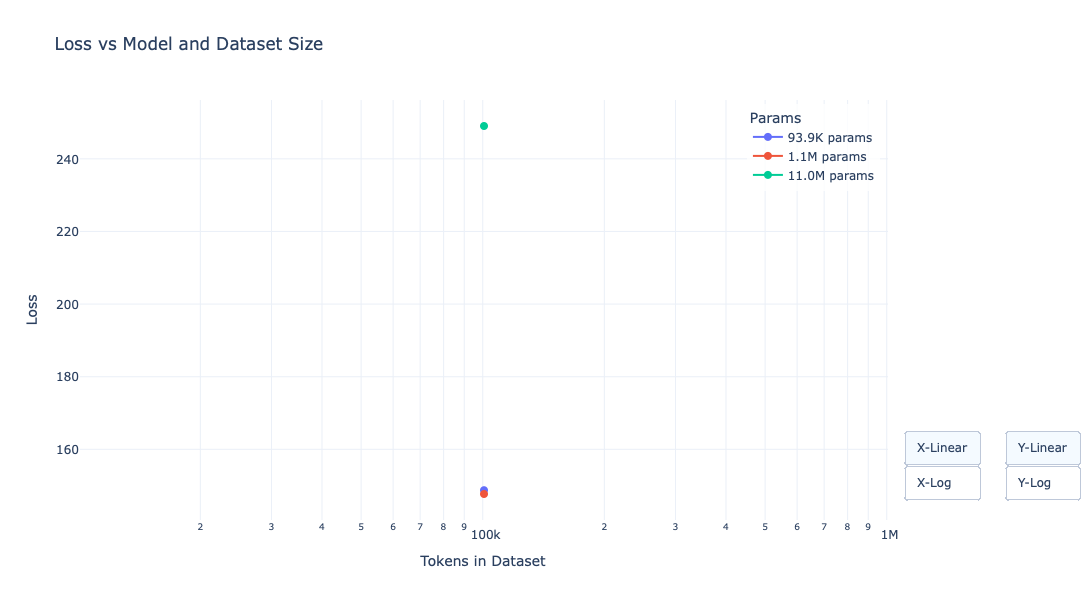

In [16]:
# This adds a new cell after your data loading code to create the desired visualization
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display
import ipywidgets as widgets
from scipy.optimize import curve_fit
import math

# Function to create the Loss vs Model and Dataset Size plot
def create_model_dataset_plot(all_detailed_runs, experiment_filename):
    fig = go.Figure()
    
    # Get data from the first experiment (or chosen one)
    detailed_runs = all_detailed_runs[experiment_filename]
    
    # Define a color map for different parameter sizes
    color_palette = px.colors.qualitative.Plotly
    model_sizes = set()
    
    # First, collect all unique model sizes for consistent color mapping
    for ds_size, runs in detailed_runs.items():
        for run_info in runs:
            num_params = run_info[0]
            model_sizes.add(num_params)
    
    model_sizes = sorted(list(model_sizes))
    color_map = {size: color_palette[i % len(color_palette)] for i, size in enumerate(model_sizes)}
    
    # Format dataset sizes and model parameters for more readable display
    def format_number(num):
        if num >= 1e9:
            return f"{num/1e9:.1f}B"
        elif num >= 1e6:
            return f"{num/1e6:.1f}M"
        elif num >= 1e3:
            return f"{num/1e3:.1f}K"
        else:
            return f"{num:.1f}"
    
    # For each model size, plot a line across dataset sizes
    for model_size in model_sizes:
        ds_sizes = []
        val_losses = []
        
        # Collect validation losses for this model size across all dataset sizes
        for ds_size, runs in detailed_runs.items():
            # Find the run with this model size
            for run_info in runs:
                num_params, val_loss, _, _ = run_info
                if num_params == model_size:
                    ds_sizes.append(ds_size)
                    val_losses.append(val_loss)
                    break
        
        # Sort by dataset size for proper line plotting
        if ds_sizes:
            sorted_indices = np.argsort(ds_sizes)
            sorted_ds_sizes = [ds_sizes[i] for i in sorted_indices]
            sorted_val_losses = [val_losses[i] for i in sorted_indices]
            
            # Add trace for this model size
            fig.add_trace(
                go.Scatter(
                    x=sorted_ds_sizes,
                    y=sorted_val_losses,
                    mode='lines+markers',
                    name=f"{format_number(model_size)} params",
                    line=dict(color=color_map[model_size]),
                    marker=dict(color=color_map[model_size], size=8)
                )
            )
    
    # Update layout
    fig.update_layout(
        title="Loss vs Model and Dataset Size",
        xaxis_title="Tokens in Dataset",
        yaxis_title="Loss",
        template="plotly_white",
        width=900,
        height=600,
        legend_title="Params",
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99,
            bgcolor="rgba(255, 255, 255, 0.8)"
        )
    )
    
    # Set log scale for x-axis by default
    fig.update_xaxes(type="log")
    
    # Add buttons for toggling axis scales
    xaxis_buttons = [
        dict(args=[{"xaxis.type": "linear"}], label="X-Linear", method="relayout"),
        dict(args=[{"xaxis.type": "log"}], label="X-Log", method="relayout")
    ]
    yaxis_buttons = [
        dict(args=[{"yaxis.type": "linear"}], label="Y-Linear", method="relayout"),
        dict(args=[{"yaxis.type": "log"}], label="Y-Log", method="relayout")
    ]
    
    fig.update_layout(
        updatemenus=[
            dict(type="buttons", direction="up", x=1.02, y=0.05, xanchor="left", yanchor="bottom",
                 showactive=True, buttons=xaxis_buttons),
            dict(type="buttons", direction="up", x=1.145, y=0.05, xanchor="left", yanchor="bottom",
                 showactive=True, buttons=yaxis_buttons)
        ]
    )
    
    # Fit power law curves for each model size if enough points
    for model_size in model_sizes:
        ds_sizes = []
        val_losses = []
        
        for ds_size, runs in detailed_runs.items():
            for run_info in runs:
                num_params, val_loss, _, _ = run_info
                if num_params == model_size:
                    ds_sizes.append(ds_size)
                    val_losses.append(val_loss)
                    break
        
        if len(ds_sizes) >= 3:  # Need at least 3 points for a reasonable fit
            sorted_indices = np.argsort(ds_sizes)
            sorted_ds_sizes = np.array([ds_sizes[i] for i in sorted_indices])
            sorted_val_losses = np.array([val_losses[i] for i in sorted_indices])
            
            # Extend the x range for the fitted curve
            min_ds = min(sorted_ds_sizes)
            max_ds = max(sorted_ds_sizes)
            extended_ds = np.logspace(math.log10(min_ds*0.5), math.log10(max_ds*2), 100)
            
            try:
                # Define power law function
                def power_law(x, a, b):
                    return a * x ** (-b)
                
                # Fit curve
                popt, _ = curve_fit(power_law, sorted_ds_sizes, sorted_val_losses, p0=(1, 0.1))
                a, b = popt
                
                # Add fitted curve
                fig.add_trace(
                    go.Scatter(
                        x=extended_ds,
                        y=power_law(extended_ds, a, b),
                        mode='lines',
                        line=dict(color=color_map[model_size], dash='dot'),
                        showlegend=False
                    )
                )
            except:
                # If curve fitting fails, just skip it
                pass
    
    return fig

# Call the function with your data
# Example usage after your data loading section:
model_dataset_fig = create_model_dataset_plot(all_detailed_runs, experiment_filenames[0])
display(model_dataset_fig)